In [1]:
import pandas as pd
import numpy as np
import sys
import os


pd.set_option('display.max_columns', None)

In [49]:
product_details = pd.read_csv(r"C:\Users\HomePC\Documents\Perishable Goods Prediction\perishable_dataset\data\product_details.csv")
store_info = pd.read_csv(r"C:\Users\HomePC\Documents\Perishable Goods Prediction\perishable_dataset\data\store_info.csv")
supplier_info = pd.read_csv(r"C:\Users\HomePC\Documents\Perishable Goods Prediction\perishable_dataset\data\supplier_info.csv")
weather_data = pd.read_csv(r"C:\Users\HomePC\Documents\Perishable Goods Prediction\perishable_dataset\data\weather_data.csv")
weekly_sales = pd.read_csv(r"C:\Users\HomePC\Documents\Perishable Goods Prediction\perishable_dataset\data\weekly_sales.csv")

In [50]:
store_info

,Store_ID,Region,Store_Size,Cold_Storage_Capacity
0,500,London,12000,3788
1,501,Midlands,5000,1086
2,502,North East,4000,998
3,503,Midlands,5000,1243
4,504,London,10000,3330
5,505,North West,3000,920
6,506,South West,4000,1262
7,507,North West,4000,1056
8,508,Midlands,5000,1023
9,509,London,10000,2762


In [51]:
print(weekly_sales.head())

  Week_Number  Product_ID  Store_ID  Units_Sold  Marketing_Spend  \
0    2024-W01        1000       500        4853           670.37   
1    2024-W01        1001       500        4274          1089.62   
2    2024-W01        1002       500        4215          1004.99   
3    2024-W01        1003       500        5768           859.45   
4    2024-W01        1004       500        3403           576.70   

   Discount_Percent  Wastage_Units  Price  
0                 0            718   2.46  
1                 0            641   1.27  
2                10            632   2.74  
3                20            853   1.82  
4                 0            503   3.46  


In [52]:
# Merge all datasets
merged_data = weekly_sales.merge(product_details, on='Product_ID', how='left') \
    .merge(store_info, on='Store_ID', how='left') \
    .merge(weather_data, on=['Week_Number', 'Region'], how='left') \
    .merge(supplier_info, on='Supplier_ID', how='left')

merged_data.dropna(inplace=True)

### Feature Selection with Mutual Info Regression

                  Feature  Mutual Information
3           Wastage_Units            3.514983
6        Product_Category            0.330136
5            Product_Name            0.328945
7         Shelf_Life_Days            0.246339
4                   Price            0.158418
8                  Region            0.142491
10  Cold_Storage_Capacity            0.140844
9              Store_Size            0.126480
12               Rainfall            0.081920
11        Avg_Temperature            0.075603
14          Supplier_Name            0.073818
16        Supply_Capacity            0.072385
1         Marketing_Spend            0.031168
0             Week_Number            0.026611
2        Discount_Percent            0.011029
15         Lead_Time_Days            0.007158
13           Holiday_Flag            0.001020


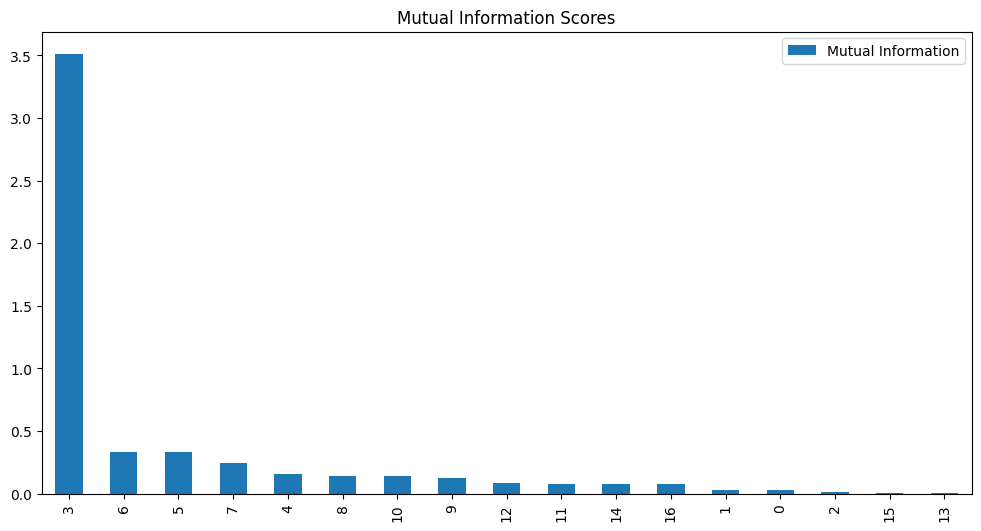

In [53]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

mutual_data = merged_data.copy()

for col in mutual_data.select_dtypes(include=['object']).columns:
    mutual_data[col] = pd.Categorical(mutual_data[col]).codes

target = mutual_data['Units_Sold']
features = mutual_data.drop(columns=['Units_Sold', 'Product_ID', 'Store_ID', 'Supplier_ID'])
mi_scores = mutual_info_regression(features, target)
mi_scores = mi_scores = pd.DataFrame({
    'Feature': features.columns,
    'Mutual Information': mi_scores
})
mi_scores = mi_scores.sort_values(by='Mutual Information', ascending=False)
print(mi_scores)

mi_scores.plot(kind='bar', figsize=(12, 6))
plt.title('Mutual Information Scores')
plt.show()

In [22]:
training_features = mi_scores.head(10)['Feature'].tolist()

### Feature Encoding

In [54]:
print(merged_data[training_features].select_dtypes(include=['object']).nunique())

main_data = merged_data[training_features].copy()
merged_data[training_features].select_dtypes(include=['object'])

Product_Category     4
Product_Name        48
Region               6
dtype: int64


,Product_Category,Product_Name,Region
0,Bakery,Whole Wheat Bread 800g,London
1,Bakery,White Sandwich Loaf,London
2,Bakery,Croissant 4-pack,London
3,Bakery,Blueberry Muffins 6-pack,London
4,Bakery,Chocolate Chip Cookies,London
...,...,...,...
37435,Beverages,English Breakfast Tea 80bags,South West
37436,Beverages,Sparkling Water 1L,South West
37437,Beverages,Lemonade 2L,South West
37438,Beverages,Protein Shake 4-pack,South West


In [56]:
norminal_columns = ['Product_Category', 'Region']
high_cardinality_columns = ['Product_Name']

for col in norminal_columns:
    dummies = pd.get_dummies(main_data[col], prefix=col)
    dummies = dummies.astype(int)
    main_data = pd.concat([main_data, dummies], axis=1)
    main_data.drop(columns=[col], inplace=True)

In [57]:
for col in high_cardinality_columns:
    target_mean = main_data.groupby(col)['Price'].mean()
    main_data[col] = main_data[col].map(target_mean)

In [58]:
main_data.dtypes

Wastage_Units                   int64
Product_Name                  float64
Shelf_Life_Days                 int64
Price                         float64
Cold_Storage_Capacity           int64
Store_Size                      int64
Rainfall                      float64
Avg_Temperature               float64
Product_Category_Bakery         int64
Product_Category_Beverages      int64
Product_Category_Dairy          int64
Product_Category_Meat           int64
Region_London                   int64
Region_Midlands                 int64
Region_North East               int64
Region_North West               int64
Region_South East               int64
Region_South West               int64
dtype: object

In [62]:
main_data['Units_Sold'] = merged_data['Units_Sold'].values

In [63]:
main_data

,Wastage_Units,Product_Name,Shelf_Life_Days,Price,Cold_Storage_Capacity,Store_Size,Rainfall,Avg_Temperature,Product_Category_Bakery,Product_Category_Beverages,Product_Category_Dairy,Product_Category_Meat,Region_London,Region_Midlands,Region_North East,Region_North West,Region_South East,Region_South West,Units_Sold
0,718,2.439103,4,2.46,3788,12000,23.0,9.9,1,0,0,0,1,0,0,0,0,0,4853
1,641,2.326103,2,1.27,3788,12000,23.0,9.9,1,0,0,0,1,0,0,0,0,0,4274
2,632,2.388256,2,2.74,3788,12000,23.0,9.9,1,0,0,0,1,0,0,0,0,0,4215
3,853,2.486821,4,1.82,3788,12000,23.0,9.9,1,0,0,0,1,0,0,0,0,0,5768
4,503,2.420526,4,3.46,3788,12000,23.0,9.9,1,0,0,0,1,0,0,0,0,0,3403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37435,22,4.127949,246,1.62,1001,3000,16.2,8.7,0,1,0,0,0,0,0,0,0,1,895
37436,38,4.121154,186,5.05,1001,3000,16.2,8.7,0,1,0,0,0,0,0,0,0,1,1558
37437,24,4.200910,356,5.72,1001,3000,16.2,8.7,0,1,0,0,0,0,0,0,0,1,993
37438,54,4.151782,158,3.82,1001,3000,16.2,8.7,0,1,0,0,0,0,0,0,0,1,2168


## Building Base Model

In [64]:
def train_linear_model(data):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

    X = data.drop(columns=['Units_Sold'])
    y = data['Units_Sold']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"RMSE: {rmse}")
    print(f"R^2: {r2}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")

    return model

In [66]:
model = train_linear_model(main_data)

RMSE: 459.77520702937835
R^2: 0.8409817646968243
MAE: 314.18599218447025
MAPE: 0.22952415273014226


In [ ]:
def train_rf_model(data):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

    X = data.drop(columns=['Units_Sold'])
    y = data['Units_Sold']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    import pickle 
    with open('rf_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    import json
    with open('schema.json', 'w') as f:
        json.dump({"features": X.columns.tolist()}, f)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"RMSE: {rmse}")
    print(f"R^2: {r2}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")

    return model

In [70]:
model = train_rf_model(main_data)

RMSE: 30.55129778838351
R^2: 0.9992978738324326
MAE: 7.629575320512819
MAPE: 0.005632249705933769


### Feature Engineering Task

According to mutual_info_regression, week_number appears not to add much value. Now engineer the week number feature into actual date and try with the mutual info